Mode decomposition of emotional arcs!
----------------------------------------------

This second version uses only the linear algebra version of the SVD.

In [1]:
from os import listdir
from os.path import isfile, join
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.storyLab import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

from tqdm import tqdm

In [2]:
# # all our essentials
# from matplotlib import rc,rcParams
# from matplotlib.colors import Colormap
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false')

# rc('font', family='serif')
# rc('font', family='cmr10')
# rc('text', usetex='true')
# # this should accomplish the same thing
# rcParams['text.usetex'] = True
# rcParams['text.latex.preamble'] = r'\usepackage{hyperref}'
# rcParams['text.latex.unicode'] = True

# rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

# import matplotlib
# matplotlib.use("pgf")
# pgf_with_custom_preamble = {
#     "text.usetex": True,
#     "text.latex.unicode": True,
#     "pgf.preamble": [
#         r"\usepackage{hyperref}"
#         ]
# }
# matplotlib.rcParams.update(pgf_with_custom_preamble)
# matplotlib.rcParams.update({'font.size': 12})
# from matplotlib import pyplot as plt

In [3]:
q = Book.objects.filter(exclude=False,length__gt=10000,length__lte=200000,
                        downloads__gte=150,numUniqWords__gt=1000,numUniqWords__lt=18000,lang_code_id=0)
q = Book.objects.filter(exclude=False,length__gt=20000,length__lte=100000,
                        downloads__gte=500,lang_code_id=0,locc_with_P=True)
print(len(q))

136


In [4]:
bins_time = 7

In [5]:
# use_cache = True
# version = "P-20K-100K-500-7pt"
# if isfile("data/gutenberg/timeseries-matrix-cache-{}.p".format(version)) and use_cache:
#     big_matrix = pickle.load(open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"rb"))
# else:
#     # load all of the timeseries into a matrix
#     big_matrix = np.ones([len(q),7])
#     # big_matrix_mean0 = np.ones(big_matrix.shape)
#     stop_val = 1.0
    
#     for i in tqdm(range(len(q))):
#         b = q[i]
#         b_data = Book_raw_data(b)
#         a = b_data.chopper_sliding(my_LabMT,num_points=bins_time,stop_val=stop_val,use_cache=True)
#         big_matrix[i,:] = b_data.timeseries
#     print(big_matrix.shape)
#     pickle.dump(big_matrix,open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"wb"),pickle.HIGHEST_PROTOCOL)

In [6]:
b = q[0]
print(b.title,b.gutenberg_id)

Alice's Adventures in Wonderland 11


In [7]:
b_data = Book_raw_data(b)
fvecs = b_data.chopper_sliding(my_LabMT,num_points=bins_time,stop_val=1.0,use_cache=True)

data/cache/11-all-fvecs-10000-7.p.lz4 True
data/cache/11-timeseries-10000-7-1.0.p.lz4 True


In [8]:
fvecs

([5.7755220620358232,
  5.7598039215686274,
  5.8112596899224807,
  5.8266405100539478,
  5.856192867905575,
  5.7898100949525233,
  5.8804599483204134],
 <7x10222 sparse matrix of type '<class 'numpy.int32'>'
 	with 7940 stored elements in LInked List format>,
 [5000.0, 8475.0, 11950.0, 15425.0, 18900.0, 22375.0, 25850.0])

In [9]:
book_fvec = np.array(fvecs[1].sum(axis=0)).squeeze()

In [10]:
book_fvec

array([3, 0, 7, ..., 0, 0, 0], dtype=int32)

In [12]:
all_shift_mags = np.zeros((10222,bins_time))
fvecs_normalized = np.zeros((10222,bins_time))
book_fvec_stopped = stopper(book_fvec,my_LabMT.scorelist,my_LabMT.wordlist)
refH = np.dot(book_fvec_stopped/sum(book_fvec_stopped),my_LabMT.scorelist)
for i in range(bins_time):
#     print(i)    
    fvec_stopped = stopper(fvecs[1][i,:].toarray().squeeze(),my_LabMT.scorelist,my_LabMT.wordlist)
    fdiff = fvec_stopped/sum(fvec_stopped)-book_fvec_stopped/sum(book_fvec_stopped)
    compH = np.dot(fvec_stopped/sum(fvec_stopped),my_LabMT.scorelist)
    hdiff = my_LabMT.scorelist-refH
    shift_mags = fdiff*hdiff
    # shift_mags = fdiff*hdiff/(compH-refH)*100
    # print(np.sum(shift_mags))
    # assert np.abs(np.sum(shift_mags) - 100.0) < .00001
    all_shift_mags[:,i] = shift_mags
    fvecs_normalized[:,i] = fvec_stopped/sum(fvec_stopped)
    sorted_shift = sorted(zip(my_LabMT.wordlist,shift_mags,),key=lambda x: abs(x[1]),reverse=True)
    print(sorted_shift[:10])

[('down', -0.020463186224519432), ('she', 0.010052984579647369), ('mad', 0.008886322543161608), ("don't", 0.0088463481392859721), ('poor', -0.0088025723543445761), ('afraid', -0.0060733928288564561), ('me', 0.0058383036343523254), ('tears', -0.0056158987711747103), ('no', -0.0053930324543262301), ('you', -0.0052839452542077989)]
[('no', -0.008999704690799722), ('not', 0.0059342608619582333), ('she', 0.0056142062094024147), ('afraid', -0.005452259887675023), ('poor', -0.0053769315811309174), ('court', 0.0050601341032427919), ('down', -0.0049185507599179704), ('bill', -0.0047343290108182697), ('me', 0.0046320845771900048), ('beg', -0.0046309740754737335)]
[('mad', -0.012904757206756511), ('no', -0.006001802156934629), ('cried', 0.0059909276202406913), ('last', -0.0058925880783481707), ('court', 0.0050601341032427919), ('baby', 0.0044717545498327961), ('never', 0.0044327112258312163), ('not', 0.0044184759548373097), ('dance', -0.0041731220151273426), ('like', 0.004109587695326467)]
[('mad

In [13]:
avg_shift_mags = np.average(all_shift_mags,axis=1)

In [14]:
avg_shift_mags[:10]

array([  1.54581698e-05,   0.00000000e+00,   1.24191106e-05,
         1.16321213e-05,   1.32959187e-05,   0.00000000e+00,
         3.64549986e-05,  -8.01360496e-06,   0.00000000e+00,
         0.00000000e+00])

In [15]:
sorted_shift = sorted(zip(my_LabMT.wordlist,avg_shift_mags,range(len(my_LabMT.wordlist))),key=lambda x: abs(x[1]),reverse=True)

In [16]:
sorted_shift[:20]

[('down', 0.00050966878864128391, 9399),
 ('she', -0.00035295202605936833, 2111),
 ('no', 0.00026509688690001663, 9523),
 ('court', -0.00024961290821577442, 9326),
 ('poor', 0.0002386428694553556, 10102),
 ('not', -0.0002287375201274916, 9264),
 ('afraid', 0.0002081479416249803, 9971),
 ('you', 0.00019767511378517493, 1940),
 ('me', -0.00019280290695164378, 1158),
 ('dance', 0.00019145804872569238, 262),
 ('beautiful', 0.00018491746591970396, 43),
 ('queen', 0.00014793468437642167, 1923),
 ('bill', 0.00014791357098480198, 9413),
 ('king', 0.00014129815896524018, 2094),
 ('wonder', -0.00013971082459623684, 525),
 ('tears', 0.00013650570899837361, 10067),
 ("won't", -0.00012714820303588508, 9382),
 ('eat', -0.00012436871043940902, 549),
 ('dear', -0.00011903590287051608, 656),
 ("don't", -0.00011407243204515638, 9375)]

In [17]:
avg_shift_mags_abs = np.average(np.abs(all_shift_mags),axis=1)
sorted_shift_avg_abs = sorted(zip(my_LabMT.wordlist,avg_shift_mags_abs,range(len(my_LabMT.wordlist))),key=lambda x: abs(x[1]),reverse=True)
sorted_shift_avg_abs[:20]

[('down', 0.0077696299661113221, 9399),
 ('mad', 0.0074306477331830736, 10002),
 ('court', 0.0068949999331062092, 9326),
 ('she', 0.0063816166847440866, 2111),
 ('no', 0.0063032632795730304, 9523),
 ("don't", 0.0060430941603369882, 9375),
 ('dance', 0.0049607403517283695, 262),
 ('not', 0.0046432163003838432, 9264),
 ('poor', 0.004569430160595799, 10102),
 ('like', 0.0044920896333947875, 391),
 ('never', 0.0043677073182383942, 9625),
 ('afraid', 0.0043132931061094903, 9971),
 ('beautiful', 0.0042258222942261735, 43),
 ('queen', 0.004041810905135227, 1923),
 ('bill', 0.0038285659656055932, 9413),
 ('me', 0.003687151896309616, 1158),
 ("won't", 0.0036551354103017794, 9382),
 ('you', 0.0036479704508904842, 1940),
 ('baby', 0.0035967383232987232, 320),
 ('gone', 0.0034354315720020656, 9575)]

In [18]:
max_shift_mags = np.max(np.abs(all_shift_mags),axis=1)
sorted_shift_max = sorted(zip(my_LabMT.wordlist,max_shift_mags,range(len(my_LabMT.wordlist))),key=lambda x: abs(x[1]),reverse=True)
sorted_shift_max[:20]

[('down', 0.020463186224519432, 9399),
 ('she', 0.014093372565108163, 2111),
 ('mad', 0.013171935722572085, 10002),
 ('court', 0.012797577460623105, 9326),
 ('like', 0.011709712705805892, 391),
 ("don't", 0.010849645920303443, 9375),
 ('not', 0.0094567858872696055, 9264),
 ('poor', 0.009050649677953845, 10102),
 ('no', 0.0090329840833488894, 9523),
 ('you', 0.008990598247419556, 1940),
 ('fee', 0.0084251242740276972, 9538),
 ('never', 0.0083768586737353375, 9625),
 ('tax', 0.007930362882341991, 9889),
 ('cat', 0.0072527986191000347, 1041),
 ('electronic', 0.0070992144490643703, 1492),
 ('king', 0.006820527237044057, 2094),
 ('united', 0.0067476667478262127, 298),
 ('dance', 0.006222660493185578, 262),
 ("won't", 0.0060897588035942881, 9382),
 ('afraid', 0.0060733928288564561, 9971)]

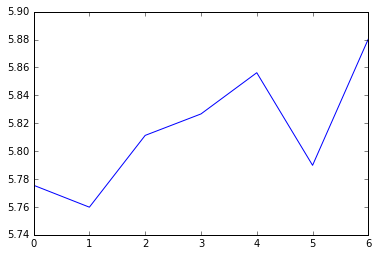

In [19]:
plt.plot(b_data.timeseries)

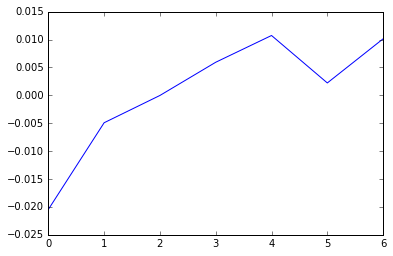

In [20]:
plt.plot(all_shift_mags[sorted_shift_avg_abs[0][2],:])

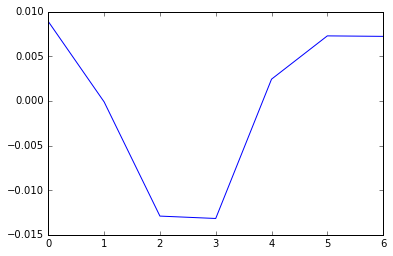

In [21]:
plt.plot(all_shift_mags[sorted_shift_avg_abs[1][2],:])

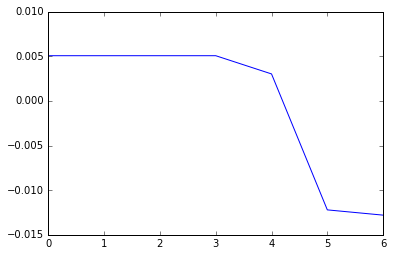

In [22]:
plt.plot(all_shift_mags[sorted_shift_avg_abs[2][2],:])

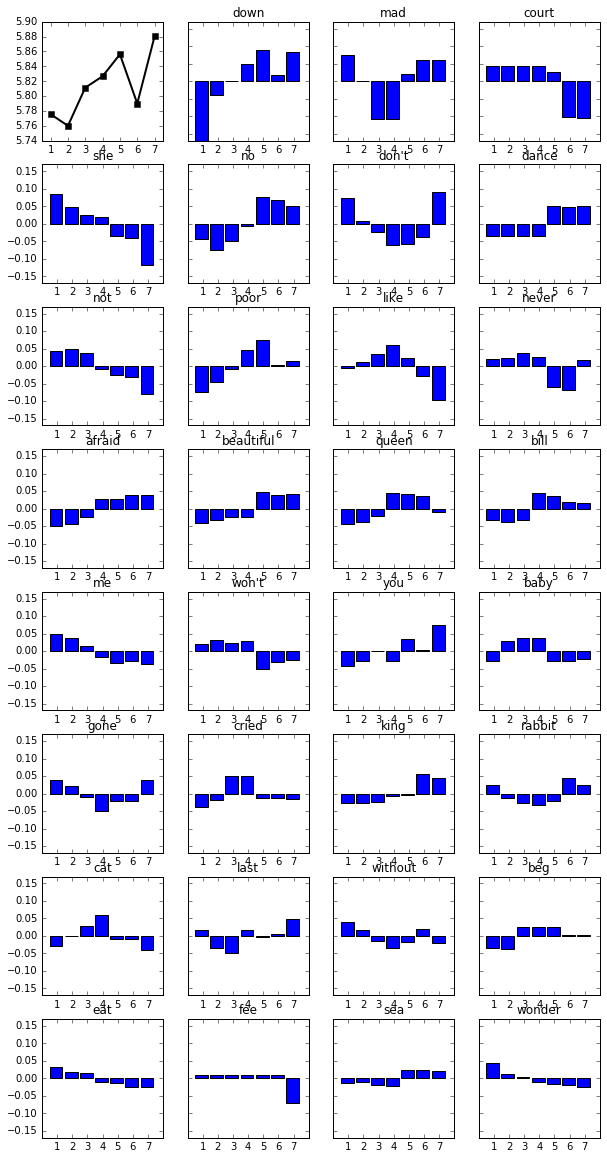

In [48]:
plt.figure(figsize=(10,20))
plt.subplot(8,4,1)
plt.plot(np.arange(bins_time)+1,b_data.timeseries,"-k",marker="s",linewidth=2)
plt.xlim([.5,bins_time+.5])
absolute_range = np.max(np.abs(all_shift_mags/(np.max(b_data.timeseries)-np.min(b_data.timeseries))))
absolute_frange = np.max(fvecs_normalized)
for i in range(31):
    plt.subplot(8,4,i+2)
    plt.bar(np.arange(bins_time)+0.5,all_shift_mags[sorted_shift_avg_abs[i][2],:]/(np.max(b_data.timeseries)-
                                                           np.min(b_data.timeseries)),
            # ".1",
            width=.85)
            # linewidth=2,
            # label=sorted_shift_avg_abs[i][0])
    # plt.plot([0,bins_time-1],[0,0],"--",linewidth=1,color=".3")
    # plt.legend()
    plt.ylim([-absolute_range,absolute_range])
    ax1 = plt.gca()
    if not (i+1)%4 == 0:
        ax1.set_yticklabels([])
    ax1.set_xticks(np.arange(bins_time)+1)
#     ax2 = ax1.twinx()
#     ax2.plot(np.arange(bins_time)+1,fvecs_normalized[sorted_shift_avg_abs[i][2],:],".6",linewidth=2)
#     ax2.set_ylim([0,absolute_frange*5])
#     if not (i+2)%4 == 0:
#         ax2.set_yticklabels([])
    plt.title(sorted_shift_avg_abs[i][0])
mysavefig("test-word-contributions.png")
mysavefig("test-word-contributions.pdf")

In [25]:
plt.bar?